### Propensión Compra - PREDICT

# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Carga modelo

In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Definir el modelo base
model = XGBClassifier()

In [6]:
import pickle
model = pd.read_pickle(r'G:\.shortcut-targets-by-id\1bm75_bWu9x17MEqz4s0y41zSeZIOecxs\Capstone Project\EasyMoney\Project Files\Propensión compra\06_Models_pickle\V2_debit_card_model.pkl')
model

XGBClassifier(base_score=None, booster=None, bootstrap=True, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, min_samples_split=4, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [7]:
model_features = list(model.feature_names_in_)

# Carga PREDICT dataset

In [8]:
df_predict = pd.read_pickle(r"G:\.shortcut-targets-by-id\1bm75_bWu9x17MEqz4s0y41zSeZIOecxs\Capstone Project\EasyMoney\Project Files\Propensión compra\05_df_preprocessed_ToPredict_pickles\V2_debit_card_last_partition.pkl") #cargar pickle carpeta 05, el del predict

In [9]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399734 entries, 5523397 to 5679912
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pk_cid                  399734 non-null  int64         
 1   pk_partition            399734 non-null  datetime64[ns]
 2   entry_date              399734 non-null  object        
 3   entry_channel           399734 non-null  object        
 4   active_customer         399734 non-null  float64       
 5   segment                 399734 non-null  object        
 6   country_id              399734 non-null  object        
 7   region_code             399734 non-null  int64         
 8   gender                  399734 non-null  object        
 9   age                     399734 non-null  int8          
 10  deceased                399734 non-null  int8          
 11  salary                  399734 non-null  float64       
 12  age_group              

In [10]:
# En el M+1 nos salen todo nulos, es correcto, ya que es la variable a predecir.
df_predict["M+1_sale_debit_card"].isnull().sum()

399734

* Importante!! Check no tenemos clientes activo

In [11]:
df_predict["debit_card"].value_counts() #ir cambiando el nombre del producto

0    399734
Name: debit_card, dtype: int64

* Eliminamos la columna del M+1_sale_payroll para poder tratar las model features por separado antes de realizar el Predict


In [12]:
df_predict = df_predict.drop("M+1_sale_debit_card", axis=1) #dropear el dabit card

* Convertimos nuestra pk_partition a datetime


In [13]:
df_predict['pk_partition'] = pd.to_datetime(df_predict['pk_partition'])

* Eliminamos las variables de "active_customer","tenencia", y el "producto" de la misma forma que hemos hecho en el notebook del modelo.

In [14]:
df_predict = df_predict.drop(["debit_card"], axis=1)

In [15]:
df_predict.set_index(['pk_cid', 'pk_partition'], inplace=True)

In [16]:
df_predict.head()

,,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,age_group,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,em_account_p,em_acount,tenencia,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_credit_card,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_em_account_p,sale_em_acount
pk_cid,pk_partition,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16063,2019-05-28,2018-11-19,KAT,0.0,02 - PARTICULARES,ES,28,H,62,0,130743.43,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16203,2019-05-28,2018-12-23,KAT,1.0,01 - TOP,ES,8,V,70,0,130743.43,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
16502,2019-05-28,2018-09-30,KHN,1.0,02 - PARTICULARES,ES,28,H,58,0,130743.43,4,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0
17590,2019-05-28,2016-12-18,KAT,1.0,02 - PARTICULARES,ES,28,V,55,0,407281.12,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17799,2019-05-28,2018-01-04,KAT,1.0,02 - PARTICULARES,ES,28,H,47,0,84511.86,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 399734 entries, (16063, Timestamp('2019-05-28 00:00:00')) to (1553689, Timestamp('2019-05-28 00:00:00'))
Data columns (total 39 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   entry_date              399734 non-null  object 
 1   entry_channel           399734 non-null  object 
 2   active_customer         399734 non-null  float64
 3   segment                 399734 non-null  object 
 4   country_id              399734 non-null  object 
 5   region_code             399734 non-null  int64  
 6   gender                  399734 non-null  object 
 7   age                     399734 non-null  int8   
 8   deceased                399734 non-null  int8   
 9   salary                  399734 non-null  float64
 10  age_group               399734 non-null  int8   
 11  short_term_deposit      399734 non-null  int8   
 12  loans                   399734 non-null  int8   
 1

In [18]:
df_predict.shape

(399734, 39)

In [19]:
df_predict.isnull().sum()

entry_date                0
entry_channel             0
active_customer           0
segment                   0
country_id                0
region_code               0
gender                    0
age                       0
deceased                  0
salary                    0
age_group                 0
short_term_deposit        0
loans                     0
mortgage                  0
funds                     0
securities                0
long_term_deposit         0
em_account_pp             0
credit_card               0
payroll                   0
pension_plan              0
payroll_account           0
emc_account               0
em_account_p              0
em_acount                 0
tenencia                  0
sale_loans                0
sale_mortgage             0
sale_funds                0
sale_securities           0
sale_long_term_deposit    0
sale_em_account_pp        0
sale_credit_card          0
sale_payroll              0
sale_pension_plan         0
sale_payroll_account

# Encoding Categoricos

In [20]:
#Columnas para el Encoding

enc_ = list(df_predict.select_dtypes(include=['object','category']).columns)
enc_

['entry_date', 'entry_channel', 'segment', 'country_id', 'gender']

In [21]:
for i in list(df_predict[enc_].columns):
  print(i)
  print('Unique:',df_predict[i].nunique())
  print(df_predict[i].value_counts(normalize=True),'\n')

entry_date
Unique: 1474
2017-07-28    0.008178
2017-10-03    0.007925
2017-08-04    0.006584
2016-10-14    0.006284
2016-08-03    0.004818
2018-08-01    0.004493
2018-07-25    0.004383
2018-10-10    0.004268
2015-08-06    0.003810
2017-07-21    0.003752
2015-08-02    0.003615
2015-08-03    0.003602
2016-10-11    0.003572
2018-10-19    0.003482
2016-08-10    0.003455
2018-09-16    0.003452
2018-09-23    0.003382
2018-09-15    0.003370
2018-10-09    0.003367
2017-09-24    0.003322
2017-09-17    0.003310
2017-08-06    0.003305
2018-07-21    0.003272
2015-08-01    0.003267
2018-09-21    0.003240
2018-09-22    0.003212
2017-07-30    0.003195
2016-07-22    0.003195
2015-08-09    0.003190
2015-08-07    0.003172
2017-09-23    0.003145
2015-07-24    0.003120
2016-10-28    0.003090
2019-02-28    0.003002
2018-09-24    0.002994
2016-10-10    0.002994
2018-10-28    0.002982
2018-09-30    0.002982
2018-10-22    0.002942
2018-07-27    0.002942
2018-08-05    0.002934
2015-07-30    0.002932
2015-10-01

Para Encoding a traves de .map()

- country_id (0.99% de nuestros clientes son de España, vamos a transformar ES en 1 y el resto en 0)
- entry_channel (KHE KHQ KFC son 74% de los clientes)

In [22]:
df_predict["entry_channel"].value_counts()

KHE        188654
KHQ         73766
KFC         45776
KHM         24585
KAT         20351
KHK         12986
KHN         12262
KHD          4719
UNKNOWN      4456
KFA          3729
RED          3140
KHL          2039
KHF          1292
KHO          1029
KAZ           261
KHC           250
KHP            84
KBG            77
KEH            43
007            41
KAG            23
KAS            20
013            18
KAA            14
KBZ            11
KAY            10
KAR             9
KCC             7
KFD             7
KAF             7
KAB             7
KHS             5
KAW             5
KCH             4
KCB             3
KDH             3
KAH             3
KAQ             3
KAM             3
KFF             2
KFL             2
KAJ             2
KAD             2
KDT             2
KAE             2
KEY             2
KBH             1
KCK             1
KBW             1
KAK             1
KFK             1
KDR             1
KGN             1
KGC             1
KBU             1
KGX       

In [23]:
# Encoding entry_channel
encoder_map = {'KHE': 1, 'KHQ': 2, 'KFC': 3}

In [24]:
df_predict['encoded_entry_channel'] = df_predict['entry_channel'].map(encoder_map).fillna(4)

In [25]:
# Encoding country_id
encoder_map2 = {'ES': 1}

In [26]:
df_predict['encoded_country_id'] = df_predict['country_id'].map(encoder_map2).fillna(0)

In [27]:
df_predict.drop(['entry_channel', 'country_id'], axis=1, inplace=True)
df_predict.columns

Index(['entry_date', 'active_customer', 'segment', 'region_code', 'gender',
       'age', 'deceased', 'salary', 'age_group', 'short_term_deposit', 'loans',
       'mortgage', 'funds', 'securities', 'long_term_deposit', 'em_account_pp',
       'credit_card', 'payroll', 'pension_plan', 'payroll_account',
       'emc_account', 'em_account_p', 'em_acount', 'tenencia', 'sale_loans',
       'sale_mortgage', 'sale_funds', 'sale_securities',
       'sale_long_term_deposit', 'sale_em_account_pp', 'sale_credit_card',
       'sale_payroll', 'sale_pension_plan', 'sale_payroll_account',
       'sale_emc_account', 'sale_em_account_p', 'sale_em_acount',
       'encoded_entry_channel', 'encoded_country_id'],
      dtype='object')

Para One Hot Encoding
- gender
- segment
- entry_date (nos elimineremos el "day" para quedarnos con el "month-date")

Modificamos las variables de la columna 'entry-date' para quedarnos con mm-yyy

In [28]:
# Convert 'entry_date' column to datetime type
df_predict['entry_date'] = pd.to_datetime(df_predict['entry_date'])

In [29]:
# Extract month and year and create a new column
df_predict['month_year_entry'] = df_predict['entry_date'].dt.strftime('%Y-%m')

In [30]:
df_predict.drop(['entry_date'], axis=1, inplace=True)

In [31]:
ohe_cols = list(df_predict.select_dtypes(include=['object','category']).columns)
ohe_cols

['segment', 'gender', 'month_year_entry']

In [32]:
# Aplicamos One Hot Encoding en los categoricos restantes
df_predict_enc = pd.get_dummies(df_predict, columns=ohe_cols)
df_predict_enc.shape

(399734, 95)

# Variables altamente correlacionadas

En preprocessing del predict no repetimos el proceso de las variables altamente correlacionadas, ya que aquí no tenemos el target, simplemente eliminamos las mismas variables que en el proceso inicial.

In [34]:
F_to_delete = ['payroll',
 'sale_payroll']

In [35]:
df_predict_enc.drop(F_to_delete, axis=1, inplace=True)
df_predict_enc.shape

(399734, 93)

# Baja Varianza

Para el proceso de la baja varianza, lo mismo que en el caso de las variables altamente correlacionadas. Simplemente eliminamos las mismas variables que en el proceso inicial.

In [36]:
#eliminar las variables de baja varianza
cols_lowvar =  ['deceased', 'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'em_account_pp', 'em_account_p', 'sale_loans', 'sale_mortgage', 'sale_funds', 'sale_securities', 'sale_long_term_deposit', 'sale_em_account_pp', 'sale_credit_card', 'sale_pension_plan', 'sale_payroll_account', 'sale_emc_account', 'sale_em_account_p', 'encoded_country_id', 'month_year_entry_2015-01', 'month_year_entry_2015-02', 'month_year_entry_2015-03', 'month_year_entry_2015-04', 'month_year_entry_2015-05', 'month_year_entry_2015-06', 'month_year_entry_2016-01', 'month_year_entry_2016-02', 'month_year_entry_2016-03', 'month_year_entry_2016-04', 'month_year_entry_2016-05', 'month_year_entry_2016-06', 'month_year_entry_2017-02', 'month_year_entry_2017-03', 'month_year_entry_2017-04', 'month_year_entry_2017-05', 'month_year_entry_2017-06', 'month_year_entry_2018-03', 'month_year_entry_2018-04', 'month_year_entry_2018-05', 'month_year_entry_2018-06', 'month_year_entry_2018-12', 'month_year_entry_2019-01', 'month_year_entry_2019-02', 'month_year_entry_2019-03', 'month_year_entry_2019-04']

In [37]:
df_predict_enc.drop(columns=cols_lowvar, inplace=True)
df_predict_enc.shape

(399734, 47)

## Definition of features

In [38]:
features = df_predict_enc.columns
X = df_predict_enc[features]

In [39]:
sample_predict = pd.DataFrame(X)

In [40]:
sample_predict.head()

,,active_customer,region_code,age,salary,age_group,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,em_acount,tenencia,sale_em_acount,encoded_entry_channel,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_UNKNOWN,gender_H,gender_V,month_year_entry_2015-07,month_year_entry_2015-08,month_year_entry_2015-09,month_year_entry_2015-10,month_year_entry_2015-11,month_year_entry_2015-12,month_year_entry_2016-07,month_year_entry_2016-08,month_year_entry_2016-09,month_year_entry_2016-10,month_year_entry_2016-11,month_year_entry_2016-12,month_year_entry_2017-01,month_year_entry_2017-07,month_year_entry_2017-08,month_year_entry_2017-09,month_year_entry_2017-10,month_year_entry_2017-11,month_year_entry_2017-12,month_year_entry_2018-01,month_year_entry_2018-02,month_year_entry_2018-07,month_year_entry_2018-08,month_year_entry_2018-09,month_year_entry_2018-10,month_year_entry_2018-11,month_year_entry_2019-05
pk_cid,pk_partition,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16063,2019-05-28,0.0,28,62,130743.43,4,0,0,0,0,0,0,0,0,4.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
16203,2019-05-28,1.0,8,70,130743.43,4,0,0,0,0,0,1,1,0,4.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16502,2019-05-28,1.0,28,58,130743.43,4,0,0,0,0,1,1,2,0,4.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
17590,2019-05-28,1.0,28,55,407281.12,4,0,0,0,0,0,0,0,0,4.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17799,2019-05-28,1.0,28,47,84511.86,3,0,0,0,0,0,1,1,0,4.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [41]:
#Dropeamos el últimos mes de entrada de clientes porque no existe.

In [42]:
sample_predict.drop(["month_year_entry_2019-05"],axis=1, inplace=True)

# Check model features

* Comprobar que tenemos en el dataset preprocesado todas las model features, de lo contrario no podremos hacer predict.
* Ordenar las variables en mismo orden que las model features

In [43]:
# Check features matched features model
features_predict = list(sample_predict.columns)
model_features = list(model.feature_names_in_)

In [44]:
len(features_predict)

46

In [45]:
len(model_features)

46

In [46]:
features_predict == model_features

True

In [47]:
missing_features = set(features_predict) - set(model_features)
print("Variables que no coinciden = 0" if not missing_features else "Variables que no coinciden: {}".format(missing_features))


Variables que no coinciden = 0


# Rescaling

* Si se entrenó el modelo con un dataset estandarizado, estandarizar con mismo scaler.

In [48]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from scipy import stats

In [49]:
# Cargamos el scaler del train-test

In [50]:
scaler = pd.read_pickle(r'G:\.shortcut-targets-by-id\1bm75_bWu9x17MEqz4s0y41zSeZIOecxs\Capstone Project\EasyMoney\Project Files\Propensión compra\07_Scalers\V2_scaler_debit_card.pkl') #cargar el scaler
scaler

StandardScaler()

In [51]:
# Estandarización: transform() en predict
scaler

X_predict_std = scaler.transform(sample_predict)

X_predict_std = pd.DataFrame(data = X_predict_std, columns=sample_predict.columns, index=sample_predict.index)

In [52]:
X_predict_std.head()

,,active_customer,region_code,age,salary,age_group,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,em_acount,tenencia,sale_em_acount,encoded_entry_channel,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_UNKNOWN,gender_H,gender_V,month_year_entry_2015-07,month_year_entry_2015-08,month_year_entry_2015-09,month_year_entry_2015-10,month_year_entry_2015-11,month_year_entry_2015-12,month_year_entry_2016-07,month_year_entry_2016-08,month_year_entry_2016-09,month_year_entry_2016-10,month_year_entry_2016-11,month_year_entry_2016-12,month_year_entry_2017-01,month_year_entry_2017-07,month_year_entry_2017-08,month_year_entry_2017-09,month_year_entry_2017-10,month_year_entry_2017-11,month_year_entry_2017-12,month_year_entry_2018-01,month_year_entry_2018-02,month_year_entry_2018-07,month_year_entry_2018-08,month_year_entry_2018-09,month_year_entry_2018-10,month_year_entry_2018-11
pk_cid,pk_partition,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16063,2019-05-28,-1.403059,0.142900,2.416359,0.067597,2.445206,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,-1.794010,-1.39203,-0.239766,1.119601,-0.133012,1.139647,-1.017501,-0.201266,1.056775,-1.056775,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,7.593493
16203,2019-05-28,0.712728,-1.348422,3.067858,0.067597,2.445206,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,0.557411,-0.23917,-0.239766,1.119601,7.518097,-0.877465,-1.017501,-0.201266,-0.946275,0.946275,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692
16502,2019-05-28,0.712728,0.142900,2.090609,0.067597,2.445206,-0.130937,-0.145411,-0.294,-0.367365,3.585139,0.557411,0.91369,-0.239766,1.119601,-0.133012,1.139647,-1.017501,-0.201266,1.056775,-1.056775,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,5.509363,-0.179,-0.131692
17590,2019-05-28,0.712728,0.142900,1.846297,1.380527,2.445206,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,-1.794010,-1.39203,-0.239766,1.119601,-0.133012,1.139647,-1.017501,-0.201266,-0.946275,0.946275,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,7.813403,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692
17799,2019-05-28,0.712728,0.142900,1.194798,-0.151899,0.914775,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,0.557411,-0.23917,-0.239766,1.119601,-0.133012,1.139647,-1.017501,-0.201266,1.056775,-1.056775,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,7.366085,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692


In [53]:
X_predict_std.tail()

,,active_customer,region_code,age,salary,age_group,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,em_acount,tenencia,sale_em_acount,encoded_entry_channel,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_UNKNOWN,gender_H,gender_V,month_year_entry_2015-07,month_year_entry_2015-08,month_year_entry_2015-09,month_year_entry_2015-10,month_year_entry_2015-11,month_year_entry_2015-12,month_year_entry_2016-07,month_year_entry_2016-08,month_year_entry_2016-09,month_year_entry_2016-10,month_year_entry_2016-11,month_year_entry_2016-12,month_year_entry_2017-01,month_year_entry_2017-07,month_year_entry_2017-08,month_year_entry_2017-09,month_year_entry_2017-10,month_year_entry_2017-11,month_year_entry_2017-12,month_year_entry_2018-01,month_year_entry_2018-02,month_year_entry_2018-07,month_year_entry_2018-08,month_year_entry_2018-09,month_year_entry_2018-10,month_year_entry_2018-11
pk_cid,pk_partition,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1553685,2019-05-28,-1.403059,-0.975591,1.601985,0.067597,2.445206,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,-1.79401,-1.39203,-0.239766,1.119601,-0.133012,-0.877465,-1.017501,4.96856,-0.946275,0.946275,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692
1553686,2019-05-28,-1.403059,1.112259,-0.189638,-0.008893,-0.615656,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,-1.79401,-1.39203,-0.239766,1.119601,-0.133012,-0.877465,-1.017501,4.96856,1.056775,-1.056775,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692
1553687,2019-05-28,-1.403059,0.142900,-0.922575,-0.008893,-0.615656,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,-1.79401,-1.39203,-0.239766,1.119601,-0.133012,-0.877465,-1.017501,4.96856,-0.946275,0.946275,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692
1553688,2019-05-28,-1.403059,0.963126,0.869048,-0.017287,0.914775,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,-1.79401,-1.39203,-0.239766,1.119601,-0.133012,-0.877465,-1.017501,4.96856,1.056775,-1.056775,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692
1553689,2019-05-28,-1.403059,-0.379063,0.624736,-0.017287,0.914775,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,-1.79401,-1.39203,-0.239766,1.119601,-0.133012,-0.877465,-1.017501,4.96856,-0.946275,0.946275,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692


In [54]:
X_predict_std.head()

,,active_customer,region_code,age,salary,age_group,long_term_deposit,credit_card,pension_plan,payroll_account,emc_account,em_acount,tenencia,sale_em_acount,encoded_entry_channel,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_UNKNOWN,gender_H,gender_V,month_year_entry_2015-07,month_year_entry_2015-08,month_year_entry_2015-09,month_year_entry_2015-10,month_year_entry_2015-11,month_year_entry_2015-12,month_year_entry_2016-07,month_year_entry_2016-08,month_year_entry_2016-09,month_year_entry_2016-10,month_year_entry_2016-11,month_year_entry_2016-12,month_year_entry_2017-01,month_year_entry_2017-07,month_year_entry_2017-08,month_year_entry_2017-09,month_year_entry_2017-10,month_year_entry_2017-11,month_year_entry_2017-12,month_year_entry_2018-01,month_year_entry_2018-02,month_year_entry_2018-07,month_year_entry_2018-08,month_year_entry_2018-09,month_year_entry_2018-10,month_year_entry_2018-11
pk_cid,pk_partition,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16063,2019-05-28,-1.403059,0.142900,2.416359,0.067597,2.445206,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,-1.794010,-1.39203,-0.239766,1.119601,-0.133012,1.139647,-1.017501,-0.201266,1.056775,-1.056775,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,7.593493
16203,2019-05-28,0.712728,-1.348422,3.067858,0.067597,2.445206,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,0.557411,-0.23917,-0.239766,1.119601,7.518097,-0.877465,-1.017501,-0.201266,-0.946275,0.946275,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692
16502,2019-05-28,0.712728,0.142900,2.090609,0.067597,2.445206,-0.130937,-0.145411,-0.294,-0.367365,3.585139,0.557411,0.91369,-0.239766,1.119601,-0.133012,1.139647,-1.017501,-0.201266,1.056775,-1.056775,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,5.509363,-0.179,-0.131692
17590,2019-05-28,0.712728,0.142900,1.846297,1.380527,2.445206,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,-1.794010,-1.39203,-0.239766,1.119601,-0.133012,1.139647,-1.017501,-0.201266,-0.946275,0.946275,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,7.813403,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,-0.135757,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692
17799,2019-05-28,0.712728,0.142900,1.194798,-0.151899,0.914775,-0.130937,-0.145411,-0.294,-0.367365,-0.278929,0.557411,-0.23917,-0.239766,1.119601,-0.133012,1.139647,-1.017501,-0.201266,1.056775,-1.056775,-0.175743,-0.180353,-0.175549,-0.211504,-0.171362,-0.115518,-0.169092,-0.192079,-0.181884,-0.2334,-0.172544,-0.127985,-0.121496,-0.20075,-0.164555,-0.213638,-0.229835,-0.186807,-0.15364,7.366085,-0.134356,-0.166649,-0.154293,-0.181509,-0.179,-0.131692


In [55]:
X_predict_std.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 399734 entries, (16063, Timestamp('2019-05-28 00:00:00')) to (1553689, Timestamp('2019-05-28 00:00:00'))
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   active_customer             399734 non-null  float64
 1   region_code                 399734 non-null  float64
 2   age                         399734 non-null  float64
 3   salary                      399734 non-null  float64
 4   age_group                   399734 non-null  float64
 5   long_term_deposit           399734 non-null  float64
 6   credit_card                 399734 non-null  float64
 7   pension_plan                399734 non-null  float64
 8   payroll_account             399734 non-null  float64
 9   emc_account                 399734 non-null  float64
 10  em_acount                   399734 non-null  float64
 11  tenencia                    399734 non-null  float64


# PREDICT

* predict() y predict_proba()

In [56]:
predict = model.predict(X_predict_std)
predict_df = pd.DataFrame(predict)
predict_df.head()
predict_df.shape

(399734, 1)

In [57]:
predict_proba = model.predict_proba(X_predict_std)[:,1]
predict_proba_df = pd.DataFrame(predict_proba)
#predict_proba_df = predict_proba_df.applymap(lambda x: "{:.2f}%".format(x * 100))
predict_proba_df.shape

(399734, 1)

In [58]:
predict_df.value_counts()

0    398010
1      1724
dtype: int64

In [59]:
print(predict_df.shape,
      predict_proba_df.shape)

(399734, 1) (399734, 1)


In [60]:
df_predict_proba = pd.merge(predict_df,predict_proba_df, left_index=True,right_index=True)
df_predict_proba.columns = ["Compra", "Probabilidad de Compra"]
df_predict_proba["Probabilidad de Compra"] = df_predict_proba["Probabilidad de Compra"].round(2)
df_predict_proba.index = df_predict.index
df_predict_proba.head(10)

,,Compra,Probabilidad de Compra
pk_cid,pk_partition,,
16063,2019-05-28,0,0.00
16203,2019-05-28,0,0.01
16502,2019-05-28,0,0.03
17590,2019-05-28,0,0.01
17799,2019-05-28,0,0.02
17980,2019-05-28,0,0.02
18146,2019-05-28,0,0.01
18704,2019-05-28,0,0.04
18956,2019-05-28,0,0.01


In [61]:
df_predict_proba_sorted = df_predict_proba.sort_values(by="Probabilidad de Compra", ascending=False)
df_predict_proba_sorted.head(10)

,,Compra,Probabilidad de Compra
pk_cid,pk_partition,,
534735,2019-05-28,1,0.99
1419723,2019-05-28,1,0.99
928076,2019-05-28,1,0.99
1141932,2019-05-28,1,0.99
1226541,2019-05-28,1,0.98
1008989,2019-05-28,1,0.98
1115404,2019-05-28,1,0.98
1358262,2019-05-28,1,0.98
1108432,2019-05-28,1,0.98


In [62]:
print("Número de Clientes:", len(df_predict_proba))

Número de Clientes: 399734


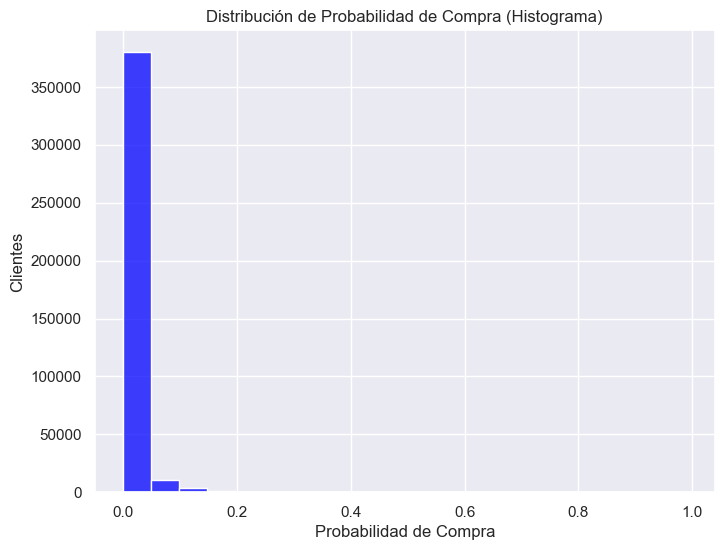

In [63]:
# Histograma
plt.figure(figsize=(8, 6))
sns.histplot(df_predict_proba["Probabilidad de Compra"], bins=20, kde=False, color='blue')
plt.xlabel("Probabilidad de Compra")
plt.ylabel("Clientes")
plt.title("Distribución de Probabilidad de Compra (Histograma)")
plt.show()

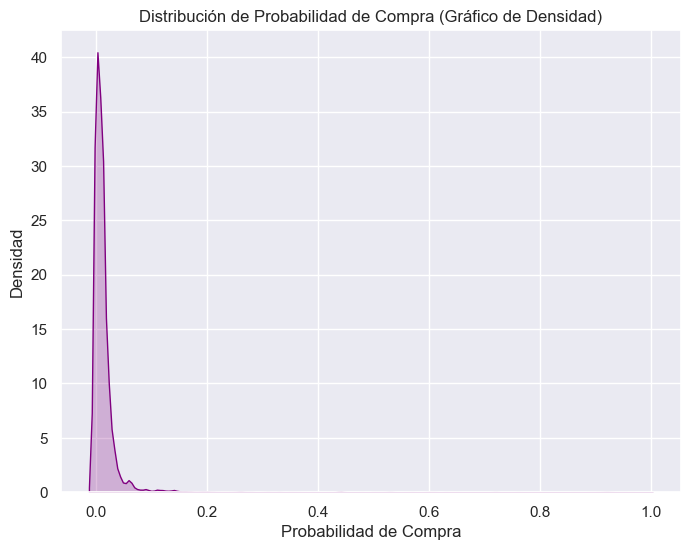

In [64]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df_predict_proba["Probabilidad de Compra"], fill=True, color='purple')
plt.xlabel("Probabilidad de Compra")
plt.ylabel("Densidad")
plt.title("Distribución de Probabilidad de Compra (Gráfico de Densidad)")
plt.show()

In [65]:
print("Número de Clientes que compran:", (df_predict_proba["Compra"]==1).sum()) #Fusionar esto con las categorias de cluster

Número de Clientes que compran: 1724


In [66]:
print("Número de Clientes con alta probabilidad de compra:", (df_predict_proba["Probabilidad de Compra"] > 0.8).sum())

Número de Clientes con alta probabilidad de compra: 682


In [67]:
print("Relación del número de clientes que compran respecto al total:", round((df_predict_proba["Compra"]==1).sum()/len(df_predict_proba),3))

Relación del número de clientes que compran respecto al total: 0.004


# Cruze con el CSV CLUSTERING

* Cargamos el CSV de clustering.

In [68]:
df_clustering = pd.read_csv(r"G:\.shortcut-targets-by-id\1bm75_bWu9x17MEqz4s0y41zSeZIOecxs\Capstone Project\EasyMoney\Project Files\Tanguy\Segmentacion\df_cluster_para_predict_proba.csv") #csv que esta en tanguy

In [69]:
df_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442995 entries, 0 to 442994
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  442995 non-null  int64 
 1   pk_cid      442995 non-null  int64 
 2   cluster     442995 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB


In [70]:
df_clustering["cluster"].value_counts()

Nuevos clientes      139145
Clientes Antiguos    120896
Clientes -40 años    111307
Clientes +40 años     47748
Multiproductos        23852
Sueldos Altos            47
Name: cluster, dtype: int64

In [71]:
df_clustering.head(5)

,Unnamed: 0,pk_cid,cluster
0,0,657826,Clientes Antiguos
1,1,586324,Nuevos clientes
2,2,600525,Nuevos clientes
3,3,556233,Nuevos clientes
4,4,890416,Nuevos clientes


In [72]:
df_clustering.columns

Index(['Unnamed: 0', 'pk_cid', 'cluster'], dtype='object')

In [73]:
df_clustering = df_clustering.drop(["Unnamed: 0"], axis=1)

In [74]:
df_clustering.set_index(["pk_cid"], inplace=True)

In [75]:
df_clustering.head(5)

,cluster
pk_cid,
657826,Clientes Antiguos
586324,Nuevos clientes
600525,Nuevos clientes
556233,Nuevos clientes
890416,Nuevos clientes


In [76]:
df_predict_proba.head(5)

,,Compra,Probabilidad de Compra
pk_cid,pk_partition,,
16063,2019-05-28,0,0.00
16203,2019-05-28,0,0.01
16502,2019-05-28,0,0.03
17590,2019-05-28,0,0.01
17799,2019-05-28,0,0.02


In [77]:
df_clustering.shape

(442995, 1)

In [78]:
df_predict_proba.shape

(399734, 2)

In [79]:
df_cross_predict_clustering = pd.merge(df_predict_proba, df_clustering, on ="pk_cid")

In [80]:
df_cross_predict_clustering.head()

,Compra,Probabilidad de Compra,cluster
pk_cid,,,
16063,0,0.00,Clientes +40 años
16203,0,0.01,Clientes +40 años
16502,0,0.03,Clientes +40 años
17590,0,0.01,Clientes +40 años
17799,0,0.02,Clientes +40 años


In [81]:
df_cross_predict_clustering_sorted= df_cross_predict_clustering.sort_values(by="Probabilidad de Compra", ascending=False)
df_cross_predict_clustering_sorted.head(10)

,Compra,Probabilidad de Compra,cluster
pk_cid,,,
534735,1,0.99,Multiproductos
1419723,1,0.99,Multiproductos
928076,1,0.99,Multiproductos
1141932,1,0.99,Multiproductos
1226541,1,0.98,Multiproductos
1008989,1,0.98,Multiproductos
1115404,1,0.98,Multiproductos
1358262,1,0.98,Multiproductos
1108432,1,0.98,Multiproductos


In [82]:
df_cross_predict_clustering.groupby("cluster")["Compra"].value_counts()

cluster            Compra
Clientes +40 años  0          41475
                   1            294
Clientes -40 años  0         104312
                   1            190
Clientes Antiguos  0         114316
                   1            155
Multiproductos     0           6693
                   1           1003
Nuevos clientes    0         131171
                   1             82
Sueldos Altos      0             43
Name: Compra, dtype: int64

In [92]:
df_cross_predict_clustering_compradores= df_cross_predict_clustering[(df_cross_predict_clustering["Probabilidad de Compra"] >= 0.5)]


# Cálculo Revenue


In [84]:
cuenta_vendida = 10
producto_de_ahorro = 40
producto_de_financiación = 60

In [88]:
resultado_original = (df_predict_proba["Compra"] == 1).sum()
revenue_debit_card = resultado_original * producto_de_financiación #cambiar cuenta_vendida por el tipo de producto

In [89]:
print("Número de Clientes que compra:", resultado_original)
print("Revenue Debit_card:", revenue_debit_card,"€")

Número de Clientes que compra: 1724
Revenue Debit_card: 103440 €


# Guarda predicciones

* Exportamos a csv la predicción de todos lo clientes, tanto los que compran como los que no.

In [90]:
df_cross_predict_clustering.to_csv(r"G:\.shortcut-targets-by-id\1bm75_bWu9x17MEqz4s0y41zSeZIOecxs\Capstone Project\EasyMoney\Project Files\Propensión compra\08_Prediccions_csv\V2_debit_card_Prediction.csv") #guardar en la 08

* Exportamos a csv solo los clientes que compran.

In [93]:
df_cross_predict_clustering_compradores.to_csv(r"G:\.shortcut-targets-by-id\1bm75_bWu9x17MEqz4s0y41zSeZIOecxs\Capstone Project\EasyMoney\Project Files\Propensión compra\08_Prediccions_csv\V3_debit_card_Prediction_Compradores.csv")